# TW233MI - Régularisation et Optimisation des modèles

## TD 2. Méthodes du premier ordre pour la régression logistique

L'objectif de ce TD est de coder les algorithmes de:
- descente en gradient (GD)
- descente de gradient par coordonnées (CD)
- descente de gradient stochastique (SGD)
- descente de gradient à variance stochastique réduite (SVRG, bonus)
- algorithme de Newton (sur TD2 en bonus)


en régression logistique, avec
pénalisation de Ridge (norme L2 sur les paramètres ou poids $\theta$).


## IMPORTANT

- Ce travail **doit être réalisé en binome**.
- **Chaque** étudiant doit envoyer son travail, en utilisant la **plateforme moodle**.
- Cela signifie que **chaque étudiant du binôme envoie le même fichier**

# Petit rappel : pas d'évaluation si vous ne respectez pas EXACTEMENT cela

## Pour générer le nom de votre fichier, utilisez ce qui suit

In [1]:
# Changez ici en utilisant vos noms et prénoms
ln1 = "servajean"
fn1 = "maximilien"

ln2 = "deudon"
fn2 = "michel"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["td3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

td3_servajean_maximilien_and_deudon_michel.ipynb


# Table des matières

[1. Présentation](#intro)<br>
[2. Fonction de coût et gradients](#models)<br>
[3. Solveurs](#solveurs)<br>
[4. Comparaison des algorithmes](#comparaison)<br>

<a id='intro'></a>
# 1. Simulation de données pour la régression logistique

In [2]:
import numpy as np
from numpy.random import randn, multivariate_normal
from scipy.linalg.special_matrices import toeplitz
import matplotlib.pyplot as plt

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11788\254488185.py:3: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


In [3]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    y[:] = 2 * y - 1 # Put the label in {-1, 1}
    return X, y

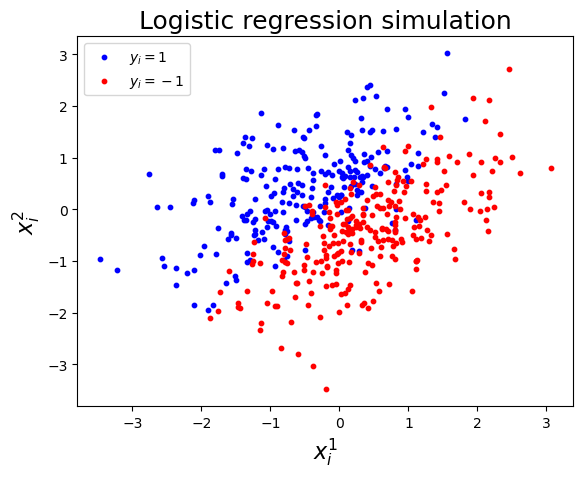

In [4]:
n_samples = 500
w0 = np.array([-3, 3.]) # poids du modèle (simulation)

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)
plt.show()

<a id='models'></a>
# 2. Fonction de coût et gradient

Nous voulons minimiser une fonction de coût $L$ avec régularisation de Ridge (L2), à savoir
$$
\arg\min_{w \in \mathbb R^d} \Big\{ l(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
où $d$ est le nombre de caractéristiques. Pour la régression logistique,
$$
L(w) = \frac 1n \sum_{i=1}^n L_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i ^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
où $n$ est la taille de l'échantillon, et où les labels $y_i \in \{ -1, 1 \}$.

Nous devons pouvoir calculer $L(w)$ et son gradient $\nabla L(w)$, afin de résoudre ce problème, ainsi que $\nabla L_i(w)$ pour les méthodes de descente de gradient stochastique et $ \frac{\partial L(w)}{\partial w_j}$ pour la descente des coordonnées.

## 2.1 Régression logistique

### QUESTIONS

1. Calculer (sur papier) les gradient $\nabla L$ et gradients stochastiques $\nabla L_i$ et $\frac{\partial L(w)}{\partial w_j}$ de $L $ pour la régression logistique (remplir la classe ci-dessous).

2. Remplissez les fonctions ci-dessous pour le calcul de $L$, $\nabla L$, $\nabla L_i$ et $\frac{\partial L(w)}{\partial w_j}$ pour la régression logistique dans la classe ModelLogReg ci-dessous (remplissez entre TODO et END TODO)

In [5]:
from numpy.linalg import norm
from scipy.optimize import check_grad

In [6]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes L(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return sum(np.log(1+np.exp(-y*X.dot(w)))) / n_samples + strength * norm(w) ** 2 / 2
        ### END TODO
       
    def grad(self, w):
        """Computes the gradient of L at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        s = 0
        for i in range(n_samples):
            s += -y[i]*X[i]/(1 + np.exp(y[i]*X[i].dot(w))) 
        return (1/n_samples)*s + strength * w
        ### END TODO

    def grad_i(self, i, w):
        """Computes the gradient of L_i at w"""
        x_i = self.X[i]
        strength = self.strength
        ### TODO
        return - y[i]*x_i /(1 +  np.exp(y[i]*x_i.dot(w))) + strength * w
        ### END TODO

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of L with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        s = 0
        for i in range(n_samples):
            s += -y[i]*X[i,j]/(1+np.exp(y[i]*X[i].dot(w)))
        return (1/n_samples)*s + strength * w[j]
        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of L"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return norm(X.T.dot(X), 2) / (4*n_samples) + self.strength
        ### END TODO

    def lip_coordinates(self):
        """Computes the Lipschitz constant of L with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return (X ** 2).sum(axis=0) / (4*n_samples) + self.strength
        ### END TODO

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of f_i"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()
        ### END TODO

## 2.2 Tester le modèle de régression logistique

In [7]:
model = ModelLogReg(X, y, strength=1e-3)
w0 = np.zeros(model.n_features)
print('Initial loss {:.2f}'.format(model.loss(w0)))
print('1 / step size (GD) {:.2f}'.format(model.lip()))
print('1 / step size (SVRG) {:.2f}'.format(model.lip_max()))
print('1 / step size (CD)', model.lip_coordinates())

Initial loss 0.69
1 / step size (GD) 0.34
1 / step size (SVRG) 3.34
1 / step size (CD) [0.27193519 0.24599057]


<a id='solveurs'></a>
## 3. Solveurs

Nous avons maintenant une classe `ModelLogReg` qui permet de calculer $L(w)$, $\nabla L(w)$,
$\nabla L_i(w)$ et $\frac{\partial L(w)}{\partial w_j}$ pour la régression logistique avec régularisation Ridge (L2).
Nous voulons maintenant coder et comparer plusieurs solveurs pour minimiser $L$

<a id='tools'></a>
## 3.1. Config pour les solveurs

In [8]:
# Point de départ de tous les solveurs (paramètres initiaux)
w0 = np.zeros(model.n_features)

# Nombre d'iterations (fixe)
n_iter = 50

# Echantillonage aléatoire pour les solveurs stochastiques (sgd, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [9]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Descente de gradient

### QUESTIONS

1. Terminez la fonction `gd` ci-dessous qui implémente l'algorithme de descente de gradient
- Testez-la en utilisant la cellule suivante

In [10]:
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        w = w - step * model.grad(w)
        ### END TODO
        callback(w)
    return w

In [11]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 3.26e-01
      20 | 3.11e-01
      30 | 3.07e-01
      40 | 3.06e-01
      50 | 3.05e-01


<a id='cgd'></a>

## 3.3 Descente de gradient par coordonnées

### QUESTIONS

1. Terminez la fonction `cgd` ci-dessous qui implémente l'algorithme de descente de gradient de coordonnées
- Testez-la en utilisant la cellule suivante

In [12]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        eta = model.lip_coordinates()
        for j in range(n_features):
            w[j] = w[j] - (1/eta[j]) * model.grad_coordinate(j, w)
        ### END TODO
        callback(w)
    return w

In [13]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 3.13e-01
      20 | 3.07e-01
      30 | 3.05e-01
      40 | 3.05e-01
      50 | 3.05e-01


<a id='sgd'></a>
## 3.4. Descente de gradient stochastique

### QUESTIONS

1. Terminez la fonction `sgd` ci-dessous qui implémente le premier algorithme de descente de gradient stochastique
- Testez-la en utilisant la cellule suivante

In [14]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent """
    
    if verbose:
        print("Lauching SGD solver...")
    w = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO
        grad = model.grad_i(i, w)
        w = w - step / (1 + idx)**0.5 * grad
        ### END TODO
        if idx % n_samples == 0:
            callback(w)
    return w

In [15]:
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

Lauching SGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 3.74e-01
      20 | 3.50e-01
      30 | 3.38e-01
      40 | 3.32e-01
      50 | 3.28e-01


<a id='svrg'></a>
## 3.5. Descente de gradient stochastique variance réduite

In [16]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient (SVRG) descent 
    R. Johnson & T. Zhang. Accelerating SGD using predictive variance reduction.
    Advances in neural information processing systems. 2013.
    """
    
    if verbose:
        print("Lauching SVRG solver...")
    w = w0.copy()
    w_old = w.copy()
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter): 
        # Après chaque passe : il faut incrémenter k, mettre à jour Wk, w
        if idx % n_samples == 0:
            w = w_old
            grad = model.grad(w)
            w_t = w_old
            w_old = 0
        
        i = idx_samples[idx]
        w_t = w_t - step * (model.grad_i(i, w_t) - model.grad_i(i, w) + grad)
        w_old += w_t / n_samples   
        if idx % n_samples == 0:
            callback(w)
    return w

In [17]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

Lauching SVRG solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 3.05e-01
      20 | 3.05e-01
      30 | 3.05e-01
      40 | 3.05e-01
      50 | 3.05e-01


<a id='comparaison'></a>
# 4. Comparaison des algorithms

In [18]:
callbacks = [callback_gd, callback_cgd, callback_sgd, callback_svrg]
names = ["GD", "CGD", "SGD", "SVRG"]
callback_long = inspector(model, n_iter=1000, verbose=False)

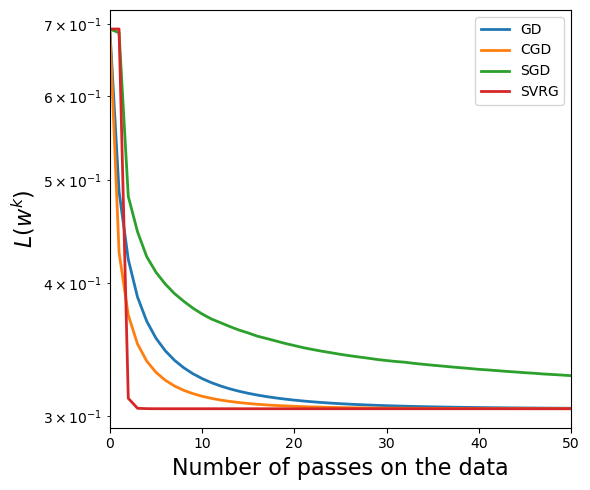

In [19]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives #- obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$L(w^k)$", fontsize=16)
plt.legend()
plt.tight_layout()

### QUESTIONS

1. Comparez les minimiseurs que vous obtenez en utilisant les différents algorithmes, avec un grand et un petit nombre d'itérations.

2. En régression logistique, étudier l'influence de la corrélation
  des caractéristiques sur les performances des algorithmes d'optimisation. Expliquer.

3. En régression logistique, étudier l'influence du niveau de pénalisation (régularisation) sur les performances des algorithmes d'optimisation. Expliquer.

4. (FACULTATIF) Modifiez les algorithmes et essayez-les pour la pénalisation L1 $pen(w) = \lambda \sum_{j=1}^d |w_j|$